Reminder: set your runtime hardware to use a GPU so that it doesn't take too long to run the models

#Pre-run (imports and datasets)

###Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from keras import metrics

np.random.seed(42)
tf.random.set_seed(42)

###dataset loading

In [2]:
C10D = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [3]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.cifar10.load_data()
xtrain = xtrain/255
xtest = xtest/255

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
#Load adv dataset

#load from Gitlab:
import urllib.request
urlpath = 'https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/FGSM_evasion_attack/Y2023/Key_Models_And_Datasets/'

# filename = 'x10000adv.npy'
# urllib.request.urlretrieve(urlpath+filename, filename)
# xadv = np.load(filename)/255

# filename = 'y10000adv.npy'
# urllib.request.urlretrieve(urlpath+filename, filename)
# yadv = np.load(filename)

# filepath = "/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/New Datasets"
filename = "xadv10kNORM.npy"
urllib.request.urlretrieve(urlpath+filename, filename)
xadv = np.load(filename)
filename = "yadv10kNORM.npy"
urllib.request.urlretrieve(urlpath+filename, filename)
yadv = np.load(filename)

##FGSM functions

In [5]:
#This method is the backbone of all of the examples. It is all that you essentially need to do FGSM for classifications.
def FGSM(model, input, target, eps=.01):
  input = tf.cast(input, tf.float32) #The gradient tape methods used in the function require the data to be in a tf dataset
  loss_object = tf.keras.losses.CategoricalCrossentropy()
  with tf.GradientTape() as tape:
    tape.watch(input)
    prediction = model(input)
    loss = -loss_object(target, prediction)
  gradient = tape.gradient(loss, input) #This is the key line that generated the gradients
  signed_grad = tf.sign(gradient)
  return (signed_grad*eps).numpy()

In [6]:
#this function is nessecary because FGSM needs a specific format for the target label
def giveLabel(label, total):
  labelx = tf.one_hot(label,total)
  return tf.reshape(labelx, (1,total))

In [7]:
def Iterate(func,model,input,target,eps,steps):
  temp = input
  for x in range(steps):
    noise = func(model, temp, target, eps/steps)
    temp = np.clip(temp+noise, 0, 1)
  return temp

In [8]:
#this function essentially just does the same as the last one, but it does it for each of the possible classifications.
#It then stores each of the adversaries it creates, and also formats the output in a nice way.
def getTable(stepfunc,func,model,input,labelFunc,eps,steps):
  advlist = []
  df = pd.DataFrame(columns=range(10))
  for x in range(10):
    advlist.append(stepfunc(func, model, input, labelFunc(x,10), eps, steps))
    predictions = (model.predict(advlist[x],verbose = 0).round(3))[0]
    df.loc[x] = predictions.tolist()
  return advlist, df

##Display Functions

In [9]:
def displayPrediction(model, image, target, truelabel):
#  image = np.clip(image,0,255)
  prediction = np.argmax(model.predict(image,verbose = 0))
  # print(f"{target}")
  plt.suptitle(f"Adversary towards {target} ({C10D[ytest[target][0]]})")
  plt.title(f"Prediction: {prediction} ({C10D[prediction]}), {round(model.predict(image,verbose = 0)[0][prediction]*100,2)}%")
  # print(f"{(image[0]*255).astype(int)}")
  plt.imshow(((image[0]*255).astype(int)))
  plt.show()
  return

In [10]:
def displayAdv(model, image, target, index):
  prediction = model.predict(image,verbose = 0)
  predlabel = np.argmax(prediction)
  plt.suptitle(f"Adversary towards {target} ({C10D[target]})")
  plt.title(f"Prediction: {predlabel} ({C10D[predlabel]}), {round(np.max(prediction)*100,2)}%")
  plt.imshow(((image[0])))
  plt.show()
  return

In [11]:
def displayOriginal(model, image, index):
  prediction = np.argmax(model.predict(image,verbose = 0))
  plt.suptitle(f"Original Image: {ytest[index][0]} ({C10D[ytest[index][0]]})")
  plt.title(f"Prediction: {prediction} ({C10D[prediction]}), {round(model.predict(image,verbose = 0)[0][prediction]*100,2)}%")
  plt.imshow(np.clip(image[0],0,1))
  plt.show()

In [12]:
def compareAdv(model, clean, adv, index):
  cleanprediction = model.predict(clean,verbose = 0)
  cleanpnum = np.argmax(cleanprediction)
  advprediction = model.predict(adv,verbose = 0)
  advpnum = np.argmax(advprediction)
  plt.suptitle("Clean Image")
  plt.title(f"Original Label: {ytest[index]} ({C10D[ytest[index][0]]}), Prediction: {cleanpnum} ({C10D[cleanpnum]}), {round(np.max(cleanprediction)*100,2)}%")
  plt.imshow(clean[0])
  plt.show()
  plt.suptitle("Adv Image")
  plt.title(f"Target Label: {yadv[index][1]} ({C10D[yadv[index][1]]}), Prediction: {advpnum} ({C10D[advpnum]}), {round(np.max(advprediction)*100,2)}%")
  plt.imshow(adv[0])
  plt.show()

##Load Models

In [13]:
# classifier = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Summer 2023/Models/CIFAR10Model2N.h5")
# classifierUN = tf.keras.models.load_model(f"/content/drive/MyDrive/CEADS Project Stuff/Fall 2022/Models/CIFAR10BestModel36.h5") #uses un-normalized data
filename = 'CIFAR10Model2N.h5'
urllib.request.urlretrieve(urlpath+filename, filename)
classifier = tf.keras.models.load_model(filename)

# filename = 'CIFAR10Model36.h5'
# urllib.request.urlretrieve(urlpath+filename, filename)
# classifierUN = tf.keras.models.load_model(filename)

#FGSM Demo (using 32x32 CIFAR10 classifier)

##FGSM Creation

In [14]:
#Edit any of these values to see the result
INDEX = 5   #any number from 0 to 5000
EPS = .02  #any number from 0 to 1
TARGET = 9   #any integer from 0 to 9, what label you are perturbing the image towards
STEPS = 10  #any integer from 1 to 100 (bigger will take longer)

#don't edit this part
MODEL = classifier
input = tf.cast(np.expand_dims(xtest[INDEX],0), tf.float32)
adv = Iterate(FGSM,MODEL,input,giveLabel(TARGET,10),EPS, STEPS)
print("Done! Run the next cell to see results!")

Done! Run the next cell to see results!


Index 5, Max Epsilon: 0.02, Original Label: 6 (frog), Target Label: 9 (truck)
Original image prediction: 6 with 99.21 certainty
Adv image prediction: 9 with 99.97 certainty


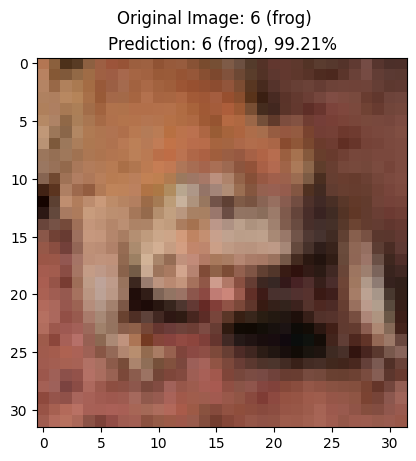

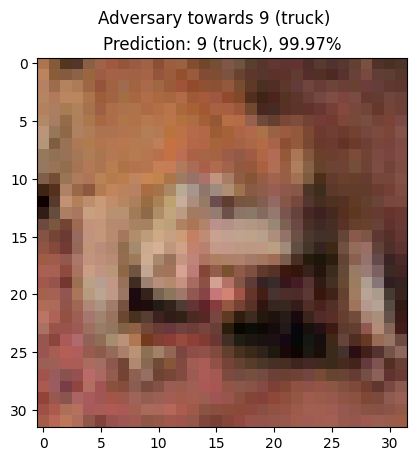

In [15]:
print(f"Index {INDEX}, Max Epsilon: {EPS}, Original Label: {ytest[INDEX][0]} ({C10D[ytest[INDEX][0]]}), Target Label: {TARGET} ({C10D[TARGET]})")
print(f"Original image prediction: {np.argmax(MODEL.predict(input,verbose = 0))} with {round(MODEL.predict(input,verbose = 0)[0][np.argmax(MODEL.predict(input,verbose = 0))]*100,2)} certainty")
print(f"Adv image prediction: {np.argmax(MODEL.predict(adv,verbose = 0))} with {round(MODEL.predict(adv,verbose = 0)[0][np.argmax(MODEL.predict(adv,verbose = 0))]*100,2)} certainty")
displayOriginal(MODEL, input, INDEX)
# displayPrediction(MODEL, adv, INDEX, TARGET)
displayAdv(MODEL, adv, TARGET, INDEX)

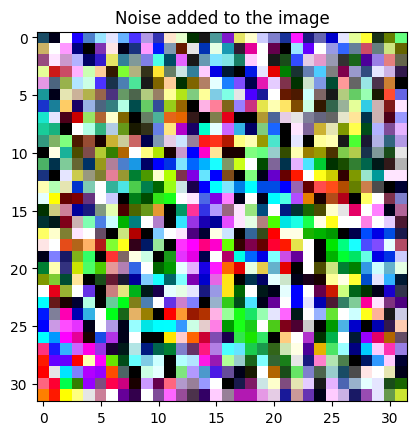

In [16]:
noise = adv[0] - input[0]
plt.imshow(np.clip((noise + .02)*25,0,1))
plt.title(f"Noise added to the image")
plt.show()

##Display Premade Datasets

For this project, something I did was creating an adversarial FGSM dataset of 10,000 images, based off of the 10,000 images in the xtest dataset. This section is mainly here to allow you to look at the adv images compared to the regular images

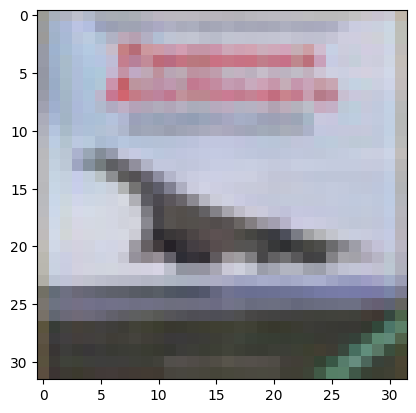

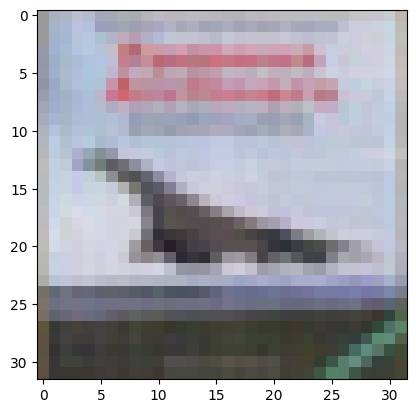

In [17]:
#print any image from both datasets
#Edit the index value to compare images
index = 3

plt.imshow(xtest[index])
plt.show()
plt.imshow(xadv[index])#from my pregenerated adv dataset
plt.show()

In [18]:
#You can use this code to evaulate the images that are printed above from the datasets I created
index = 3

prediction = classifier.predict(xtest[index:index+1], verbose = 0)
argmax = np.argmax(prediction)
print(f"Original image prediction: {argmax} ({C10D[argmax]}) with {round(np.max(prediction)*100,2)} certainty")

prediction = classifier.predict(xadv[index:index+1], verbose = 0)
argmax = np.argmax(prediction)
print(f"Adv image prediction: {argmax} ({C10D[argmax]}) with {round(np.max(prediction)*100,2)} certainty")


Original image prediction: 0 (airplane) with 81.84 certainty
Adv image prediction: 8 (ship) with 99.99 certainty


##Model Evaluation

This section is here to show off how the models do evaluated on the regular and adversarial datasets

In [19]:
classifier.evaluate(xtest, ytest)
classifier.evaluate(xadv, ytest);

313/313 [==============================] - 4s 13ms/step - loss: 3.2854 - accuracy: 0.2592
